In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = '12_combined'

folder = f'../../data/manager_v3/{run}'

train_folder = os.path.join(folder, 'metrics')
merge_file = os.path.join(folder, 'metrics.parquet')
model_folder = os.path.join(folder, 'model')

plot_folder = f'plots/{run}'

make_dir(plot_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# if not os.path.isfile(merge_file):
#     dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
#     df = pd.concat(dfs)
#     df.to_parquet(merge_file)
# else:
#     df = pd.read_parquet(merge_file)
dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
df = pd.concat(dfs)

In [3]:
df.columns

Index(['artificial_humans', 'eps', 'features', 'hidden_size', 'model',
       'job_id', 'round_number', 'sampling', 'update_step', 'metric', 'value'],
      dtype='object')

In [4]:
non_labels = ['round_number', 'sampling', 'update_step', 'metric', 'value', 'job_id']

labels = [c for c in df.columns if c not in non_labels]


In [5]:
labels

['artificial_humans', 'eps', 'features', 'hidden_size', 'model']

In [6]:
df['features'].unique()

array(['cont+round2', 'contributions', 'cont+round'], dtype=object)

In [7]:
import statsmodels.formula.api as smf
res = []
for ah in df['artificial_humans'].unique():
    for m in df['model'].unique():

        w = (
            (df['metric'] == 'common_good') &
            (df['sampling'] == 'greedy')&
            (df['artificial_humans'] == ah)&
            (df['model'] == m)
        )
        dfs = df[w].copy()
        w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
        dfs = dfs[w_max].copy()

        for l in labels:
            dfs[l] = dfs[l].astype(str)


        label_ref = {
            'eps': '0.1',
            'gamma': '1.0',
            'lr': '3.e-4',
            'memory_episodes': '100',
            'target_update_freq': '200',
            'hidden_size': '5',
            'features': 'contributions'
        }


        label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]


        results = smf.glm(f"value ~ {'+'.join(label_str)}", data=dfs).fit()
        results_df = results.summary2().tables[1]
        results_df['artificial_humans'] = ah
        results_df['model'] = m
        res.append(results_df)
        # print('metric accuracy - positive coef -> better')
        # results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')
        # print(f'{ah} | {m}')
        # print(results_df)
results_df = pd.concat(res)


results_df = results_df.reset_index()
results_df

,index,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],artificial_humans,model
0,Intercept,20.737918,0.085481,242.601870,0.000000e+00,20.570378,20.905458,complex,mlp
1,"C(eps, Treatment(reference='0.1'))[T.0.2]",-1.716246,0.076457,-22.447273,1.360662e-111,-1.866099,-1.566394,complex,mlp
2,"C(features, Treatment(reference='contributions...",1.006118,0.093640,10.744527,6.288328e-27,0.822587,1.189649,complex,mlp
3,"C(features, Treatment(reference='contributions...",-0.319193,0.093640,-3.408721,6.526829e-04,-0.502724,-0.135662,complex,mlp
4,"C(hidden_size, Treatment(reference='5'))[T.20]",3.934096,0.076457,51.455167,0.000000e+00,3.784244,4.083949,complex,mlp
5,Intercept,23.186945,0.095492,242.816171,0.000000e+00,22.999785,23.374105,complex,rnn
6,"C(eps, Treatment(reference='0.1'))[T.0.2]",-0.008529,0.085410,-0.099863,9.204533e-01,-0.175931,0.158872,complex,rnn
7,"C(features, Treatment(reference='contributions...",-1.261615,0.104606,-12.060643,1.704471e-33,-1.466639,-1.056592,complex,rnn
8,"C(features, Treatment(reference='contributions...",-1.753370,0.104606,-16.761661,4.654378e-63,-1.958394,-1.548346,complex,rnn
9,"C(hidden_size, Treatment(reference='5'))[T.20]",2.346424,0.085410,27.472337,3.759100e-166,2.179023,2.513826,complex,rnn


/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


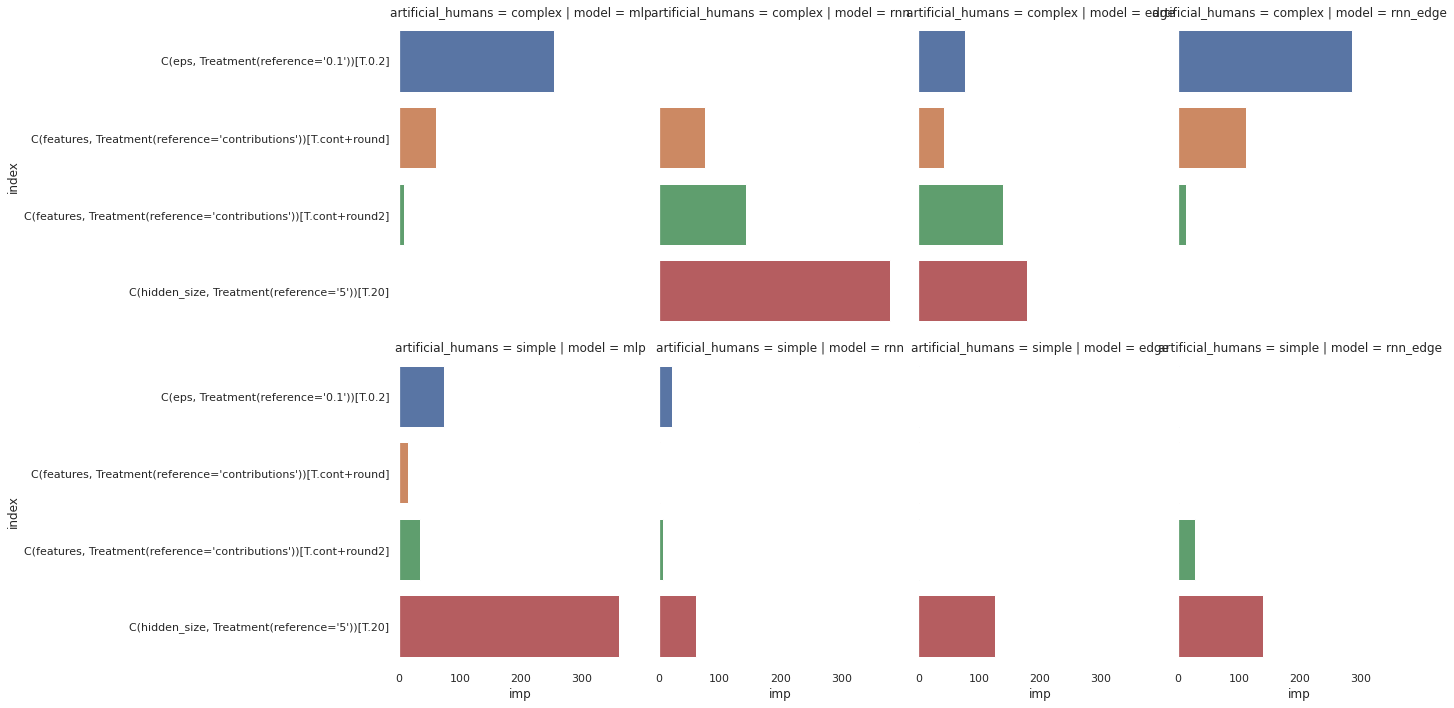

In [8]:
results_df['imp'] = - np.log(results_df['P>|z|'])

sns.catplot(data=results_df[results_df['index'] != 'Intercept'], x='imp', y='index', col='model', row='artificial_humans', kind='bar')

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


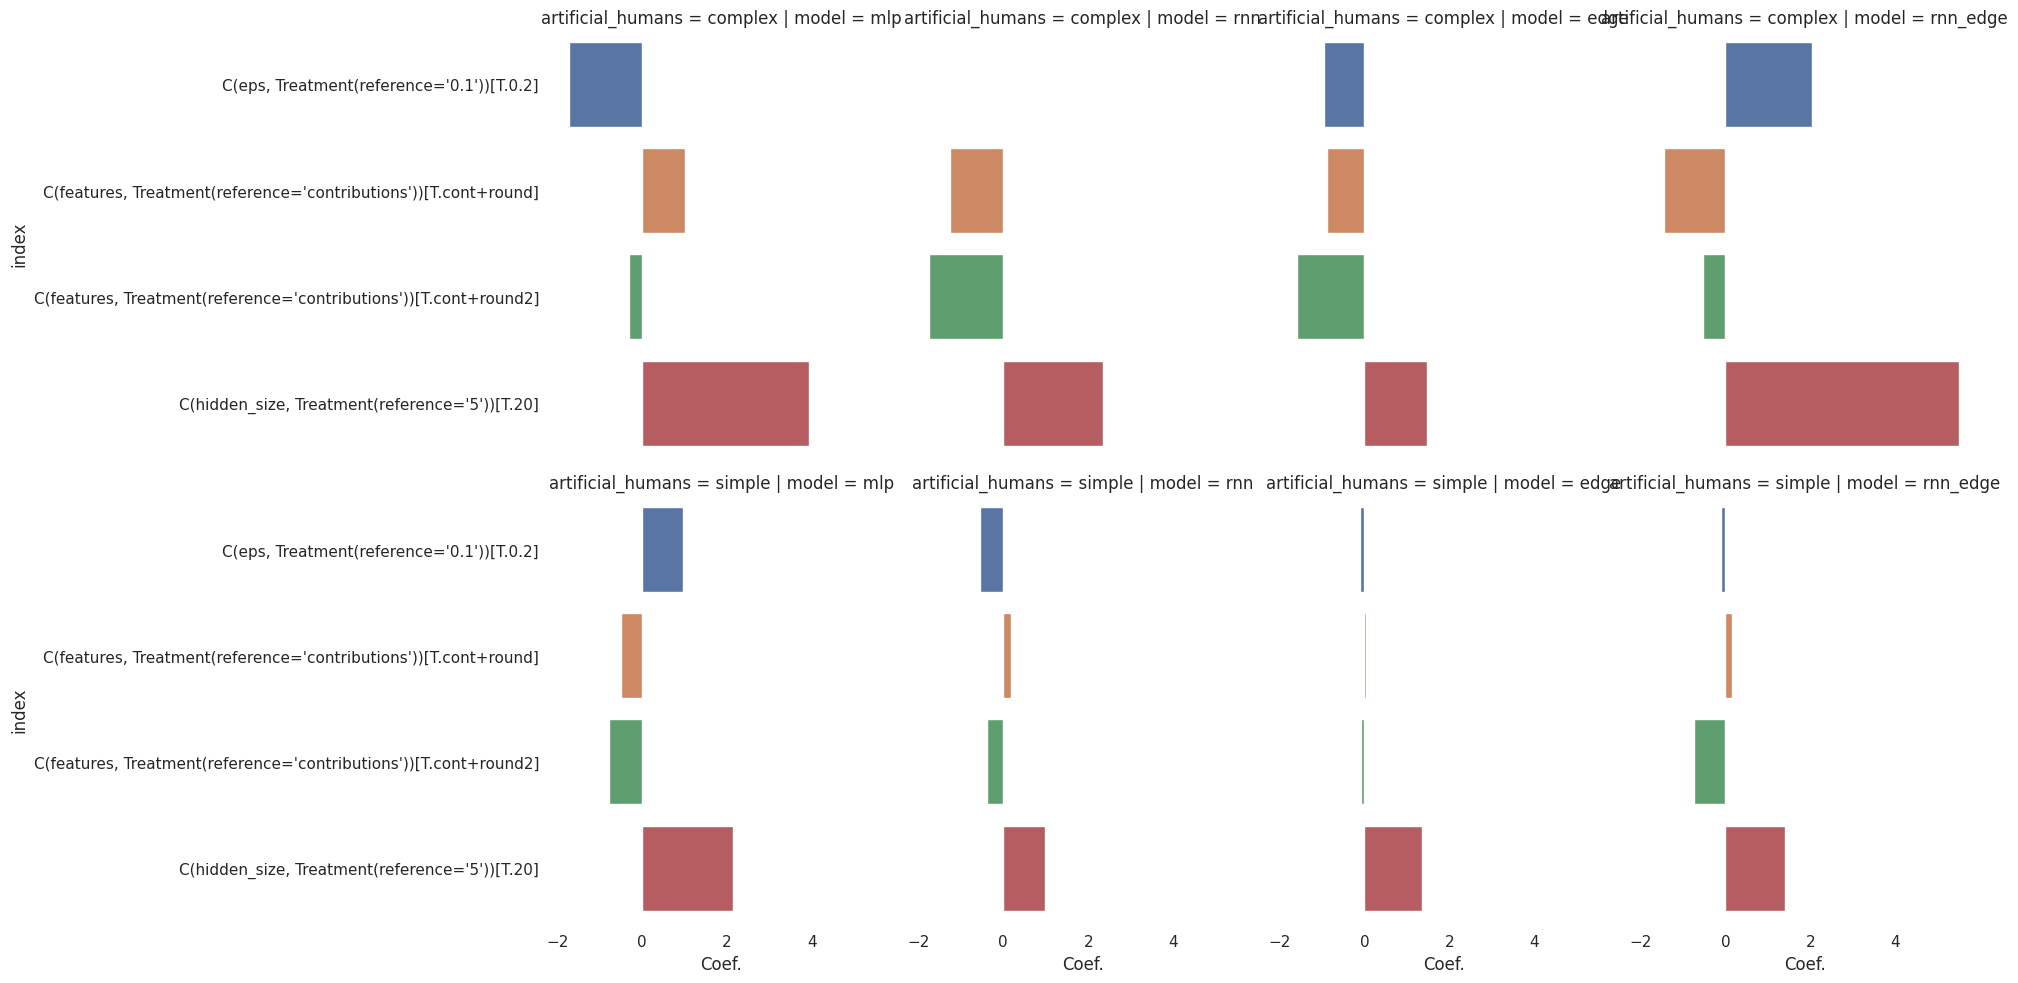

In [9]:
results_df['imp'] = - np.log(results_df['P>|z|'])

sns.catplot(data=results_df[results_df['index'] != 'Intercept'], x='Coef.', y='index', col='model', row='artificial_humans', kind='bar')

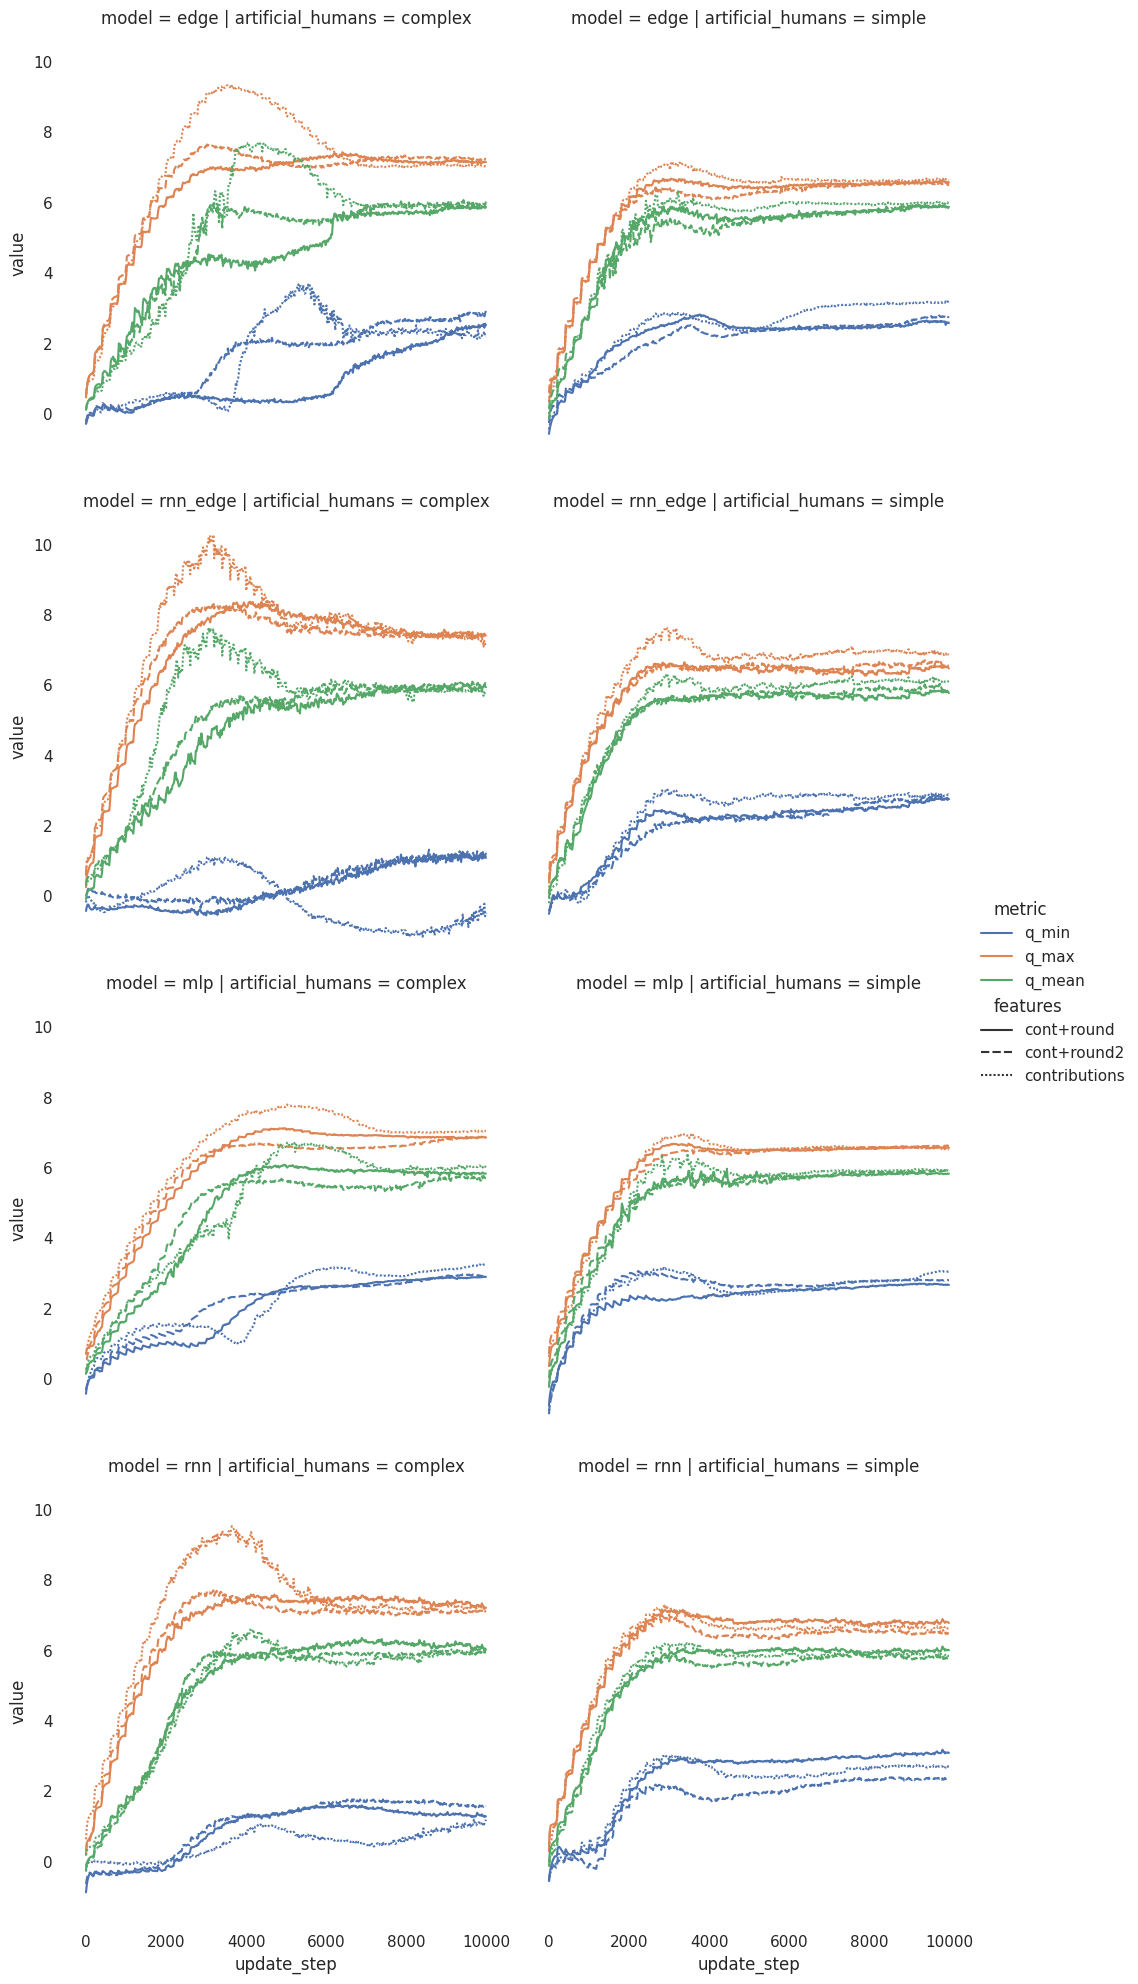

In [10]:
selection = {
    'eps': 0.2, 'gamma': 1, 'hidden_size': 20, 'lr': '3.e-4', 
    'memory_episodes': 100, 'sampling': 'greedy', 
    'target_update_freq': 200, 'features': 'contributions',
    'artificial_humans': 'complex'}

focus = ['update_step', 'metric', 'eps', 'model']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['q_min', 'q_max', 'q_mean'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

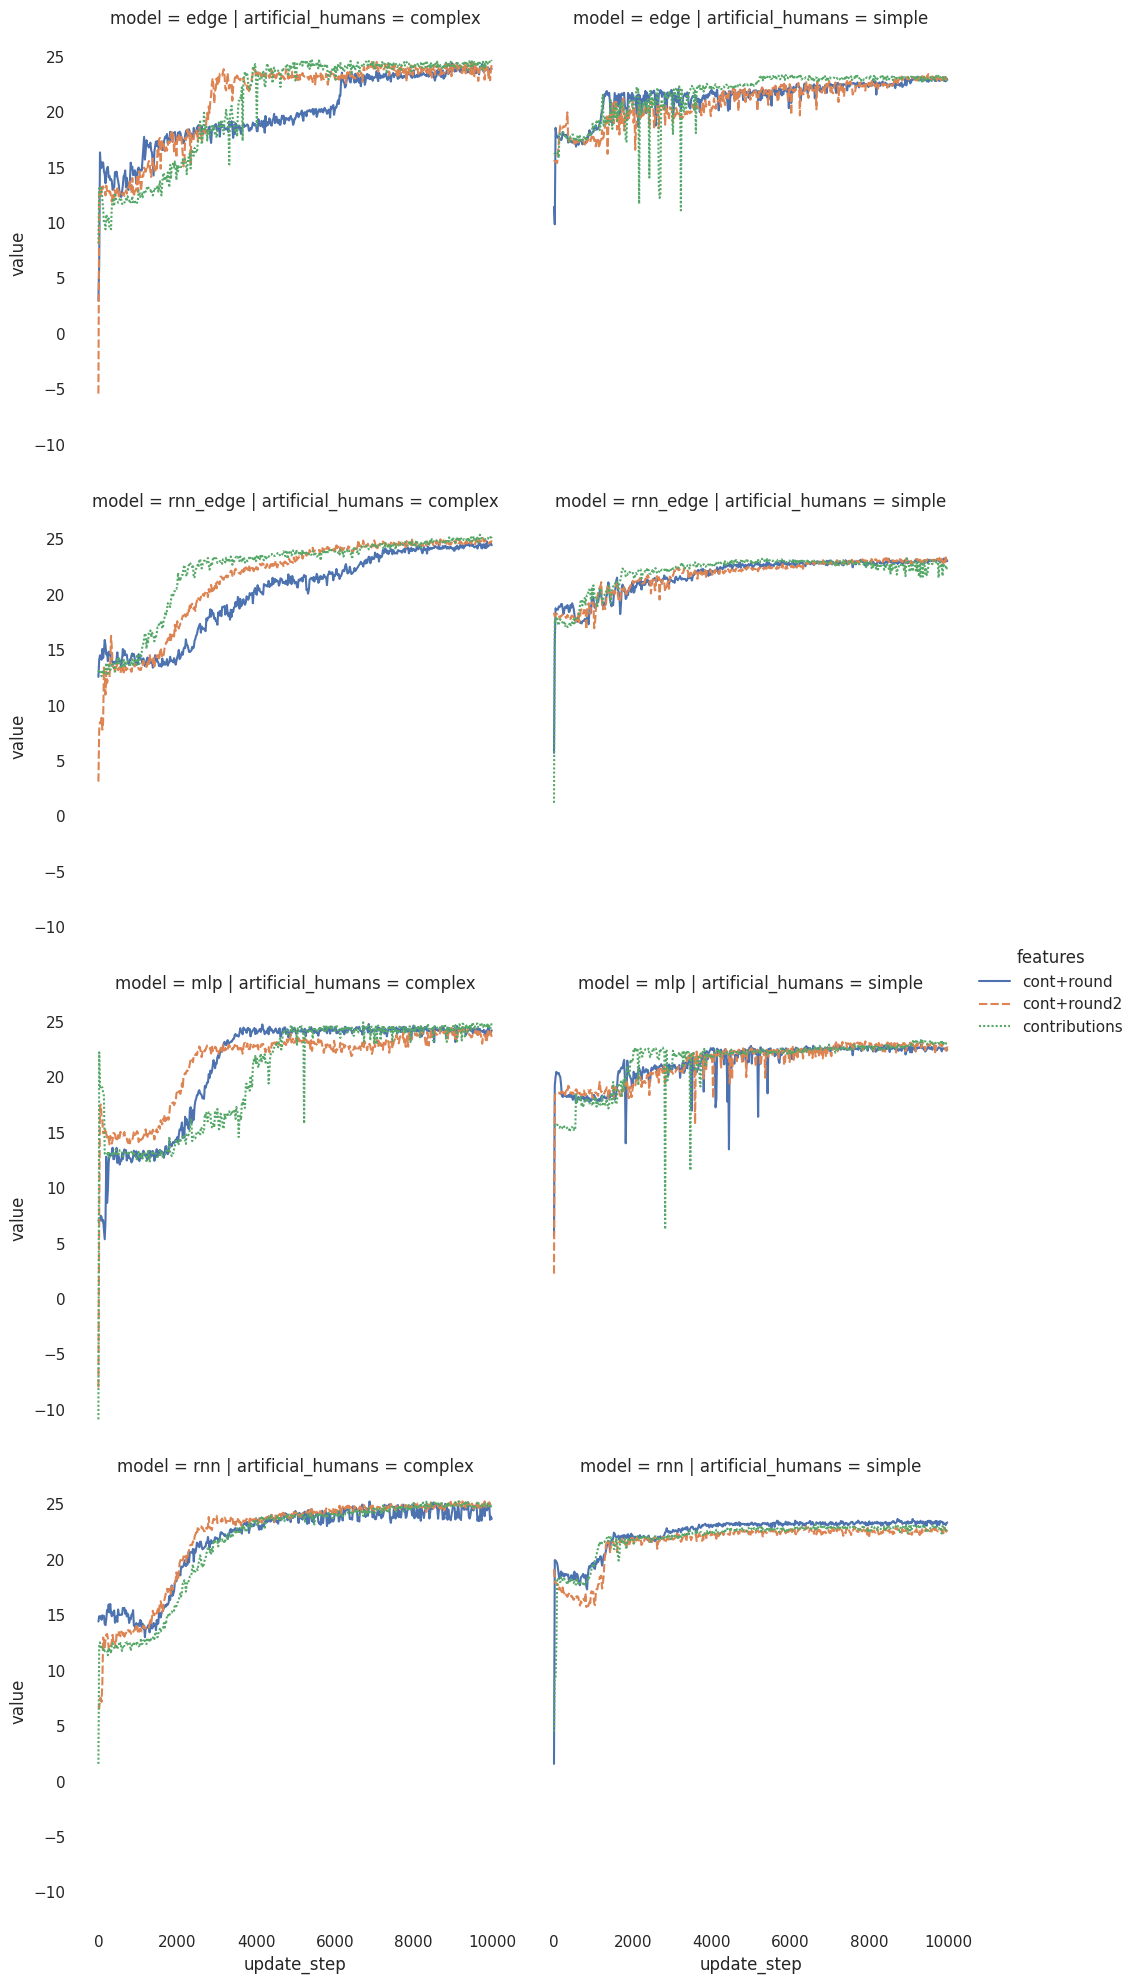

In [11]:
focus = ['update_step', 'features', 'features', 'artificial_humans', 'model']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

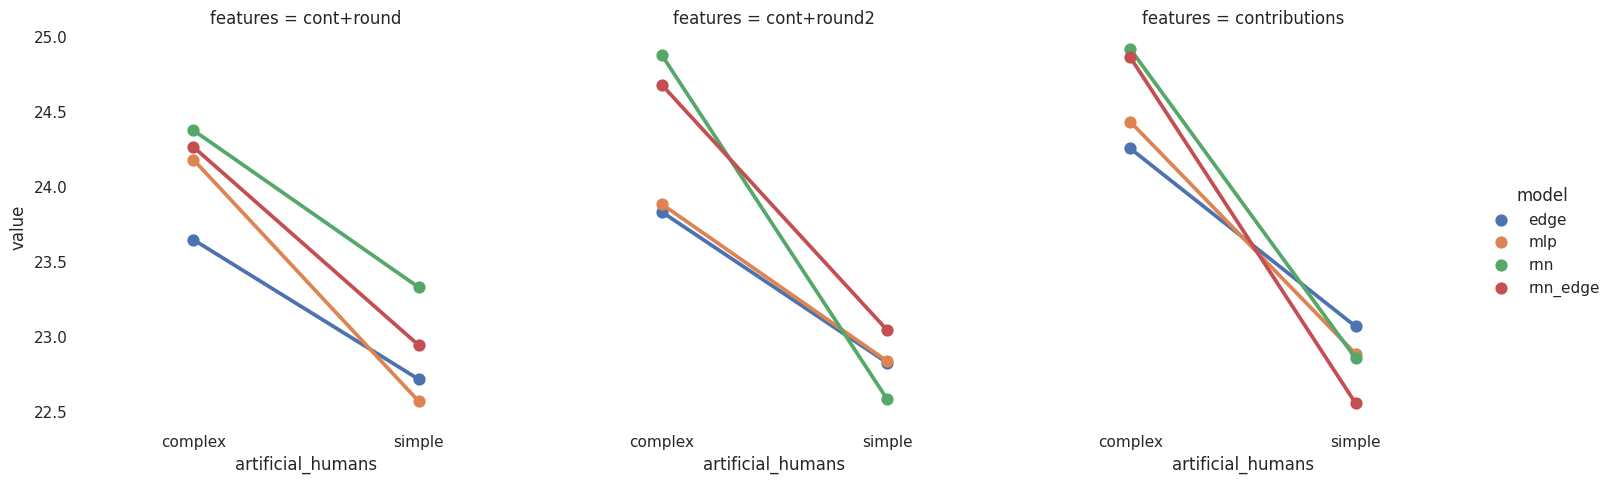

In [12]:
focus = ['update_step', 'artificial_humans', 'model', 'features']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['common_good'])
dfs = dfs[w]

w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
dfs = dfs[w_max].copy()

dfs = dfs.groupby(labels)['value'].mean().reset_index()

sns.catplot(data=dfs, y='value', hue='model', x='artificial_humans', col='features', kind='point')

<AxesSubplot:xlabel='artificial_humans', ylabel='value'>

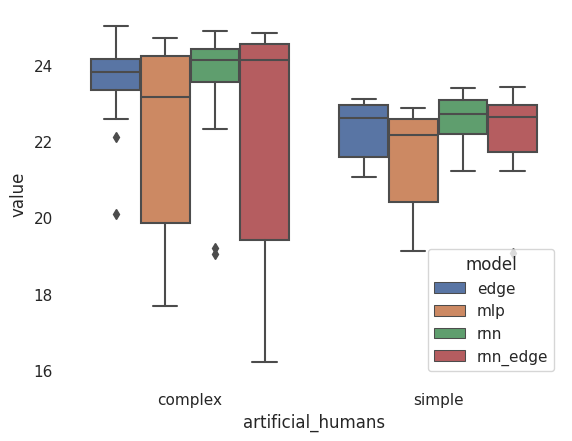

In [13]:
w = (
    (df['metric'] == 'common_good') &
    (df['sampling'] == 'greedy')
)
dfs = df[w].copy()
w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
dfs = dfs[w_max].copy()

dfs = dfs.groupby(labels)['value'].mean().reset_index()

sns.boxplot(data=dfs, y='value', hue='model', x='artificial_humans')